In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Aug 22 15:23:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


####라이브러리

In [3]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 10
learning_rate = 0.001
num_epochs = 50

In [5]:
torch.cuda.empty_cache()

1. 데이터 정의

#### A. Datasets and Preprocessing

In [6]:
#image transformation
image_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((132, 132)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])                 
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((132, 132)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

####B. DataLoader

In [7]:
os.getcwd()

'/content'

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
#The Path in which the data exists
os.listdir('./gdrive/MyDrive/ColabNotebooks/data/')

['tumor']

In [10]:
dataset = 'tumor'

train_directory = './gdrive/MyDrive/ColabNotebooks/data/tumor/Training'

test_directory = './gdrive/MyDrive/ColabNotebooks/data/tumor/Testing'

#batch size
batch_size = 32

#Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

data = {
    'train': datasets.ImageFolder(root = train_directory, transform = image_transforms['train']),
    'test': datasets.ImageFolder(root = test_directory, transform = image_transforms['test'])
}
#Mapping of the indices to the class names, in order to see the output classes of the test dataset images.
idx_to_class = {v: x for x, v in data['train'].class_to_idx.items()}
print(idx_to_class)

#Size of each datasets.
train_data_size = len(data['train'])
test_data_size = len(data['test'])

4
{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}


In [11]:
#The Size for each class in the train dataset
print(len(os.listdir(train_directory + '/glioma_tumor')))
print(len(os.listdir(train_directory + '/meningioma_tumor')))
print(len(os.listdir(train_directory + '/no_tumor')))
print(len(os.listdir(train_directory + '/pituitary_tumor')))

826
822
395
827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


meningioma_tumor no_tumor pituitary_tumor glioma_tumor


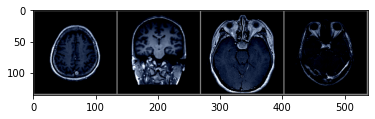

In [12]:
train_data_loader = DataLoader(data['train'], batch_size = batch_size, shuffle = True)
test_data_loader = DataLoader(data['test'], batch_size = batch_size, shuffle = False)

def showimage(img):
  img = img / 2 + 0.5
  numpy_image = img.numpy()
  plt.imshow(np.transpose(numpy_image, (1, 2, 0)))

trainloader_1 = DataLoader(data['train'], batch_size = 4, shuffle =True)
dataiter = iter(trainloader_1)
images, labels = dataiter.next()

showimage(torchvision.utils.make_grid(images))
print(' '.join('%5s' % list(idx_to_class.values())[labels[j]] for j in range(4)))

In [13]:
del trainloader_1

In [14]:
#checking the size of the datasets
train_data_size, test_data_size

(2870, 394)

# **2. 모델**

####My Model implementation take

In [15]:
resnet_model = models.resnet50(pretrained=True)
for param in resnet_model.parameters():
  param.requires_grad = True

#get the input of the fully connected layer
n_inputs = resnet_model.fc.in_features

resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 64),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(64, 64),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(64, num_classes),
                                nn.LogSoftmax(dim=1))

for name, child in resnet_model.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

resnet_model.to(device)

resnet_model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
#Intialize Criterion and Optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

In [17]:
iter(train_data_loader).__next__()

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.0837, -2.1008, -2.1008],
           [-2.1179, -2.1179, -2.1179,  ..., -2.0837, -2.1008, -2.1008],
           [-2.1179, -2.1179, -2.1179,  ..., -2.0494, -2.0665, -2.1008],
           ...,
           [-2.1008, -2.1008, -2.1008,  ..., -2.0440, -2.0440, -2.0665],
           [-2.1179, -2.1179, -2.1179,  ..., -1.9124, -2.0494, -2.0545],
           [-2.1179, -2.1179, -2.1179,  ..., -1.8945, -2.0611, -2.1008]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0007, -2.0182, -2.0182],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0007, -2.0182, -2.0182],
           [-2.0357, -2.0357, -2.0357,  ..., -1.9657, -1.9832, -2.0182],
           ...,
           [-2.0182, -2.0182, -2.0182,  ..., -1.9601, -1.9601, -1.9832],
           [-2.0357, -2.0357, -2.0357,  ..., -1.8257, -1.9657, -1.9709],
           [-2.0357, -2.0357, -2.0357,  ..., -1.8073, -1.9776, -2.0182]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.7696, -1.7870, -1.7870],
           [-

In [18]:
def train(model, loss_criterion, optimizer, epochs):
  start = time.time()           #시작 time 재기!
  history = []
  best_acc = 0.0                #Best Accuracy Value

  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    #Model to Training Mode!
    model.train()

    #Initialize Loss and Accuracy
    train_loss = 0.0
    train_acc = 0.0 

    for i, (inputs, labels) in enumerate(train_data_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      #Forward Pass
      outputs = model(inputs)

      #Loss Computation
      loss = loss_criterion(outputs, labels)

      #Back Propagation
      loss.backward()

      #Update the parameters
      optimizer.step()

      train_loss += loss.item() * inputs.size(0)
      
      #Computing the accuracy(다소 헷갈리는 파트, 다시 확인!!!)
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      acc = torch.mean(correct_counts.type(torch.FloatTensor))

      train_acc += acc.item() * inputs.size(0)

      if i % 50 == 0 and i != 0:
        print("Batch Number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

    avg_train_loss = train_loss / train_data_size
    avg_train_acc = train_acc / train_data_size
    history.append([avg_train_loss, avg_train_acc])

    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, epoch_end-epoch_start))

    if best_acc < avg_train_acc:
      best_acc = avg_train_acc
      torch.save(model, dataset + '_model_' + str(epoch))


  return model, history




In [19]:
num_epochs = 25
train_model, history = train(resnet_model, criterion, optimizer, num_epochs)

#Saving model
torch.save(history, dataset + '_history.pt')

Epoch: 1/25


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Batch Number: 050, Training: Loss: 0.6262, Accuracy: 0.7500
Epoch : 000, Training: Loss: 0.9373, Accuracy: 61.6028%, Time: 1708.1722s
Epoch: 2/25
Batch Number: 050, Training: Loss: 1.2179, Accuracy: 0.5625
Epoch : 001, Training: Loss: 0.7128, Accuracy: 73.9373%, Time: 56.1525s
Epoch: 3/25
Batch Number: 050, Training: Loss: 0.3600, Accuracy: 0.9375
Epoch : 002, Training: Loss: 0.5718, Accuracy: 79.8955%, Time: 55.9657s
Epoch: 4/25
Batch Number: 050, Training: Loss: 0.3927, Accuracy: 0.8750
Epoch : 003, Training: Loss: 0.4633, Accuracy: 84.7038%, Time: 55.8101s
Epoch: 5/25
Batch Number: 050, Training: Loss: 0.2847, Accuracy: 0.9062
Epoch : 004, Training: Loss: 0.4022, Accuracy: 85.8885%, Time: 55.8576s
Epoch: 6/25
Batch Number: 050, Training: Loss: 0.4648, Accuracy: 0.8125
Epoch : 005, Training: Loss: 0.4129, Accuracy: 85.8188%, Time: 56.0586s
Epoch: 7/25
Batch Number: 050, Training: Loss: 0.5329, Accuracy: 0.8438
Epoch : 006, Training: Loss: 0.3462, Accuracy: 89.4774%, Time: 56.2432s
Ep

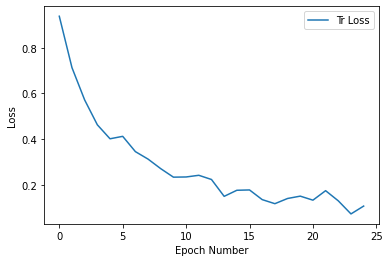

In [20]:
#Loss Examination Process
history = np.array(history)
plt.plot(history[:,0])
plt.legend(['Tr Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig(dataset+'_loss_curve.png')
plt.show()

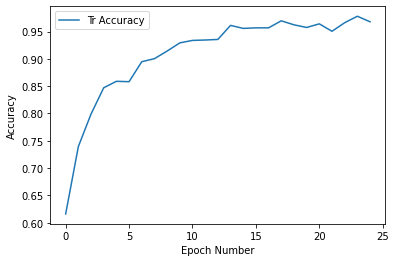

In [21]:
#Accuracy Examination Process
history = np.array(history)
plt.plot(history[:,1])
plt.legend(['Tr Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig(dataset + '_accuracy_curve.png')
plt.show()

In [22]:
# Test the model
resnet_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 76.39593908629442 %
